In [ ]:
#원하는 부분 CAM을 유도하기 위해서 mask + CAM loss(feature)로 모델을 학습
#Score-CAM으로 시각화/기본 densenet121와 CAM loss로 학습 시킨 densnet121의 차이를 보여주는 시각화

Score-CAM을 사용하기 위한 grad-cam 라이브러리 설치

In [ ]:
pip install grad-cam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import tqdm
import torch.nn.functional as F


# GPU 사용 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

기본 Dataset + CAM을 유도하기 위해 Mask를 같이 load하는 Dataset

In [ ]:
class HairLossDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')

        label = int(self.annotations.iloc[idx]['label']) - 1  # 라벨을 0부터 시작하도록 보정
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
class CAMTrainDataset(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        import os  # 다시 한 번 안전하게
        row = self.data.iloc[idx]
        filename = row['filename']
        label = int(row['label']) - 1  # 0-based label

        image_path = os.path.join(self.image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        mask_path = os.path.join(self.mask_dir, filename.replace('.jpg', '.png'))

        if not os.path.exists(mask_path):
            scalp_mask = torch.zeros((224, 224), dtype=torch.float32)
        else:
            mask = Image.open(mask_path).resize((224, 224)).convert('RGB')
            mask_np = np.array(mask)
            scalp_mask = ((mask_np[:, :, 0] == 0) &
                          (mask_np[:, :, 1] == 0) &
                          (mask_np[:, :, 2] == 255)).astype(np.float32)
            scalp_mask = torch.from_numpy(scalp_mask)

        return image, label, scalp_mask, filename

In [ ]:
mean = [0.43755555152893066, 0.39420410990715027, 0.3537991940975189]
std = [0.21359124779701233, 0.19734203815460205, 0.18219676613807678]

In [ ]:
# 데이터 변환 정의
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 검증 및 테스트용 transform (증강 없이)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 각각의 데이터셋 생성
train_dataset = CAMTrainDataset(
    csv_file="",
    image_dir="",
    mask_dir="",
    transform=train_transform
)

valid_dataset = HairLossDataset(
    csv_file='',
    root_dir='',
    transform=eval_transform
)

test_dataset = HairLossDataset(
    csv_file='',
    root_dir='',
    transform=eval_transform
)

# DataLoader 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

Score-CAM에서 relu0 layer를 거친 feature map을 사용하기 위해, block을 하나씩 가져오기

In [ ]:
class DenseNetWithRelu0(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        base = models.densenet121(pretrained=True)
        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)

        # relu0까지 명시적으로 접근 가능하도록
        self.conv0 = self.features.conv0
        self.norm0 = self.features.norm0
        self.relu0 = self.features.relu0
        self.pool0 = self.features.pool0
        self.dense1 = self.features.denseblock1
        self.trans1 = self.features.transition1
        self.dense2 = self.features.denseblock2
        self.trans2 = self.features.transition2
        self.dense3 = self.features.denseblock3
        self.trans3 = self.features.transition3
        self.dense4 = self.features.denseblock4
        self.norm5 = self.features.norm5

    def forward(self, x):
        x = self.conv0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        self.feature_map_relu0 = x  #저장

        x = self.pool0(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)
        x = self.norm5(x)

        out = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(out)

Mask와 feature map의 dice loss

In [ ]:
def feature_supervision_loss(feature_map, mask, eps=1e-6):
    """
    feature_map: (B, C, Hf, Wf)
    mask: (B, Hm, Wm) — hair=1, bald=2, background=0
    """
    mask = F.interpolate(mask.unsqueeze(1).float(), size=feature_map.shape[2:], mode='nearest')
    fg_mask = (mask > 0).float()

    activation = feature_map.norm(p=2, dim=1, keepdim=True)  # (B, 1, H, W)

    intersection = (activation * fg_mask).sum()
    loss = 1 - (2 * intersection + eps) / (activation.sum() + fg_mask.sum() + eps)
    return loss

In [ ]:
model = DenseNetWithRelu0(num_classes=7).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
lambda_cam = 1

In [ ]:
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss, train_ce, train_cam = 0.0, 0.0, 0.0
    train_corrects = 0
    train_totals = 0

    for images, labels, masks, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        ce_loss = criterion(outputs, labels)

        relu0_feature = model.feature_map_relu0
        #mask/bald 영역 전체
        cam_loss = feature_supervision_loss(relu0_feature, masks) #feature_supervision_loss

        total_loss = ce_loss + lambda_cam * cam_loss
        total_loss.backward()
        optimizer.step()

        # 누적
        train_loss += total_loss.item() * images.size(0)
        train_ce += ce_loss.item() * images.size(0)
        train_cam += cam_loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        train_corrects += (preds == labels).sum().item()
        train_totals += labels.size(0)

    # validation
    model.eval()
    valid_loss = 0.0
    valid_corrects = 0
    valid_totals = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            valid_corrects += (preds == labels).sum().item()
            valid_totals += labels.size(0)

    # 평균 계산
    train_loss /= len(train_loader.dataset)
    train_ce /= len(train_loader.dataset)
    train_cam /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    train_accuracy = train_corrects / train_totals
    valid_accuracy = valid_corrects / valid_totals

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Total Loss: {train_loss:.4f} | CE: {train_ce:.4f} | CAM: {train_cam:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Validation loss improved. Model saved.")

In [ ]:
model.load_state_dict(torch.load("", map_location=device))
model.to(device)

test 결과 확인

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
from torchvision import transforms

def load_image(image_path, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    return tensor

def evaluate_test_accuracy(model, image_dir, label_csv):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    label_df = pd.read_csv(label_csv)
    total = 0
    correct = 0

    for idx, row in tqdm(label_df.iterrows(), total=len(label_df)):
        filename = row['filename']
        image_path = os.path.join(image_dir, filename)

        label = int(row['label']) - 1 if 'label' in row else int(row[1:].values.argmax())

        try:
            input_tensor = load_image(image_path, device=device)
            with torch.no_grad():
                outputs = model(input_tensor)
                pred_index = int(torch.argmax(outputs, dim=1).item())
        except Exception as e:
            print(f"Error with {filename}: {e}")
            continue

        if pred_index == label:
            correct += 1
        total += 1

    acc = correct / total * 100 if total > 0 else 0
    print(f"Test Accuracy: {acc:.2f}%")

In [ ]:
evaluate_test_accuracy(
    model=model,
    image_dir='',
    label_csv='',
)

100%|██████████| 638/638 [00:17<00:00, 36.42it/s]

Test Accuracy: 98.75%


Score-CAM 시각화

In [ ]:
def show_score_cam_gt_pred_only(model, csv_path, image_dir, target_label, list_index, target_layer, class_labels=None, device='cuda'):
    """
    특정 label의 이미지 중 list_index번째 이미지를 불러와 GT와 예측 class에 대해 Score-CAM을 시각화.

    Args:
        model: 학습된 classification 모델
        csv_path: CSV 파일 경로 (filename, label 컬럼 포함)
        image_dir: 이미지 파일 디렉토리 경로
        target_label: 보고 싶은 라벨 (1~7처럼 실제 라벨 기준)
        list_index: 해당 라벨을 가진 이미지들 중 몇 번째를 볼지 (0부터 시작)
        target_layer: CAM 추출할 DenseNet feature 레이어
        class_labels: 클래스 이름 리스트 (선택)
        device: 'cuda' 또는 'cpu'
    """
    df = pd.read_csv(csv_path)
    filtered_df = df[df['label'] == target_label]

    if len(filtered_df) == 0:
        print(f"No samples found with label {target_label}")
        return
    if list_index >= len(filtered_df):
        print(f"Only {len(filtered_df)} samples available with label {target_label}, but list_index={list_index} was requested.")
        return

    row = filtered_df.iloc[list_index]
    img_path = os.path.join(image_dir, row['filename'])
    label = int(row['label']) - 1  # 0-based label

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])

    model.eval().to(device)

    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    image_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0
    image_np = np.clip(image_np, 0, 1)

    with torch.no_grad():
        output = model(image_tensor)
        pred_class = int(torch.argmax(output, dim=1).item())

    cam = ScoreCAM(model=model, target_layers=[target_layer])
    selected_classes = [label]
    if pred_class != label:
        selected_classes.append(pred_class)

    cams = []
    for class_idx in selected_classes:
        grayscale_cam = cam(input_tensor=image_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]
        cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        cams.append((class_idx, cam_image))

    # 시각화
    n_cols = 3
    fig, axes = plt.subplots(1, len(cams) + 1, figsize=(n_cols * 4, 4))
    axes = axes if isinstance(axes, np.ndarray) else [axes]

    axes[0].imshow(image_np)
    axes[0].set_title(f"Original\nGT: {label + 1} | Pred: {pred_class + 1}")
    axes[0].axis('off')

    for j, (class_idx, cam_img) in enumerate(cams):
        title = class_labels[class_idx] if class_labels else f"Class {class_idx + 1}"
        prefix = "[GT] " if class_idx == label else "[Pred] "
        axes[j + 1].imshow(cam_img)
        axes[j + 1].set_title(prefix + title)
        axes[j + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
show_score_cam_gt_pred_only(
    model= model,
    csv_path="",
    image_dir="",  # 이미지 디렉토리 경로
    target_label=6,               # 실제 라벨 (1~7 중 하나)
    list_index= 3,                 # 해당 라벨 내 두 번째 이미지
    target_layer= model.features.relu0,
    class_labels=["1", "2", "3", "4", "5", "6", "7"],
    device='cuda'
)

기본 densnet model과 dice loss를 추가한 model의 비교

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def show_score_cam_compare_models(model_baseline, model_cam, csv_path, image_dir, target_label, list_index, target_layer_base,target_layer,
                                  class_labels=None, device='cuda'):
    """
    CAM 없이 학습한 모델과 CAM loss로 학습한 모델이 같은 이미지를 어떻게 보는지를 시각적으로 비교.
    """



    df = pd.read_csv(csv_path)
    filtered_df = df[df['label'] == target_label]

    if len(filtered_df) == 0:
        print(f"No samples found with label {target_label}")
        return
    if list_index >= len(filtered_df):
        print(f"Only {len(filtered_df)} samples available with label {target_label}, but list_index={list_index} was requested.")
        return

    row = filtered_df.iloc[list_index]
    img_path = os.path.join(image_dir, row['filename'])
    label = int(row['label']) - 1  # 0-based

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0
    image_np = np.clip(image_np, 0, 1)

    model_baseline.eval().to(device)
    model_cam.eval().to(device)

    with torch.no_grad():
        pred_base = torch.argmax(model_baseline(image_tensor), dim=1).item()
        pred_cam = torch.argmax(model_cam(image_tensor), dim=1).item()

    cam_base = ScoreCAM(model=model_baseline, target_layers=[target_layer_base])
    cam_cam = ScoreCAM(model=model_cam, target_layers=[target_layer])

    def get_cams(cam_extractor, model_name, target_classes):
        results = []
        for class_idx in target_classes:
            grayscale_cam = cam_extractor(input_tensor=image_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]
            cam_img = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
            results.append((model_name, class_idx, cam_img))
        return results

    cams = []
    # baseline 모델의 CAM
    base_targets = [label]
    if pred_base != label:
        base_targets.append(pred_base)
    cams += get_cams(cam_base, "Baseline", base_targets)

    # CAM 학습 모델의 CAM
    cam_targets = [label]
    if pred_cam != label:
        cam_targets.append(pred_cam)
    cams += get_cams(cam_cam, "CAM", cam_targets)

    # 시각화
    n_cols = len(cams) + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))
    axes = axes if isinstance(axes, np.ndarray) else [axes]

    axes[0].imshow(image_np)
    axes[0].set_title(f"Original\nGT: {label + 1}")
    axes[0].axis('off')

    for i, (model_name, class_idx, cam_img) in enumerate(cams):
        title = class_labels[class_idx] if class_labels else f"Class {class_idx + 1}"
        prefix = "[GT]" if class_idx == label else "[Pred]"
        axes[i + 1].imshow(cam_img)
        axes[i + 1].set_title(f"{model_name} {prefix} {title}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

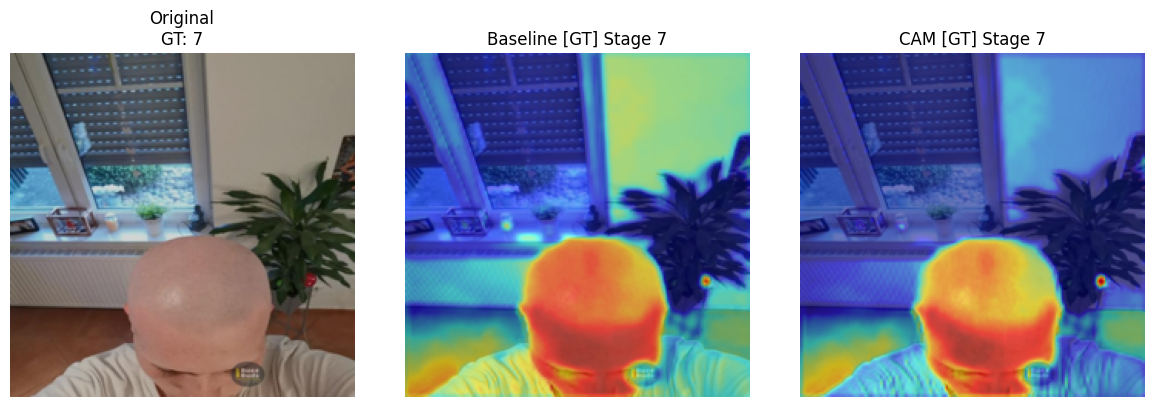

In [ ]:
show_score_cam_compare_models(
    model_baseline=model_dens,
    model_cam=model,
    csv_path='',
    image_dir='',
    target_label=7,
    list_index=3,
    target_layer_base = model_dens.features.relu0,
    target_layer=model.features.relu0,  # DenseNet의 마지막 conv block
    class_labels=[f"Stage {i}" for i in range(1, 8)]
)